# Why Uncertainty Matters
In machine learning, especially in classification tasks, it’s not enough to just predict which class a data point belongs to — we also want to know how confident the model is in that prediction. This is called uncertainty estimation. 

➡️ Example: Medical diagnosis (like cancer screening)

- **False Positive (FP)**: Predicting cancer when there isn’t any → patient gets extra tests → stressful but usually harmless.
- **False Negative (FN)**: Missing cancer → no treatment → potentially life-threatening.

This is why uncertainty estimation is critical — **it helps us make safer, more informed decisions**.


# Two Key Methods in scikit-learn for Uncertainty
Most classifiers in scikit-learn provide at least one of these two methods:

1. **`decision_function(X)`**

2. **`predict_proba(X)`**

> ✅ Many classifiers (like `SVC`, `LogisticRegression`, `GradientBoostingClassifier`) support both!

我们来构建一个GradientBoostingClassifier 分类器（同时拥有decision_function
和predict_proba 两个方法），看一下这两个函数对一个模拟的二维数据集的作用：

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.datasets import make_circles 
X, y = make_circles(noise=0.25, factor=0.5, random_state=1) 

# 为了便于说明，我们将两个类别重命名为"blue"和"red" 
y_named = np.array(["blue", "red"])[y] 

# 我们可以对任意个数组调用train_test_split 
# 所有数组的划分方式都是一致的 
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0) 

# 构建梯度提升模型 
gbrt = GradientBoostingClassifier(random_state = 0)
gbrt.fit(X_train, y_train_named)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Decision Fuction
对于二分类的情况，decision_function返回值的形状是(n_samples,)，为每个样本都返回
一个浮点数：

- **Positive value** → model favors the **“positive” class**
- **Negative value** → model favors the **“negative” class**
- **Value near zero** → model is **uncertain**

This is NOT a probability — it’s a raw score, often unbounded (can be very large or very small).

In [7]:
print("X_test.shape: {}".format(X_test.shape)) 
print("Decision function shape: {}".format( 
    gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


对于类别1来说，这个值表示模型对该数据点属于“正”类的置信程度。正值表示对正类
的偏好，负值表示对“反类”（其他类）的偏好：

In [8]:
# 显示decision_function的前几个元素 
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


### Reproduce Predictions Using Sign
我们可以通过仅查看决策函数的正负号来再现预测值：

In [9]:
print("Thresholded decision function:\n{}".format( 
    gbrt.decision_function(X_test) > 0)) 
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


####  classes_ Defines Positive/Negative Class
> ⚠️ For binary classification:
> 
> - `clf.classes_[0]` = “negative” class
> - `clf.classes_[1]` = “positive” class

```
y_named = np.array(["blue", "red"])[y]  # 0→"blue", 1→"red"
```
To fully reproduce predict(), you must use classes_.” 

### Manually Reproduce .predict()

In [11]:
# 将布尔值True/False转换成0和1 
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int) 

# 利用0和1作为classes_的索引 
pred = gbrt.classes_[greater_zero] 

# pred与gbrt.predict的输出完全相同 
print("pred is equal to predictions: {}".format( 
    np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions: True


➡️ This proves:

You can fully reproduce predict() using only decision_function and classes_. 

This is critical for understanding how scikit-learn internally maps scores to labels.

### Range of Decision Function Values

In [15]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
    np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


**由于可以任意缩放，因此decision_function的输出往往很难解释**

### Visualization
在下面的例子中，我们利用颜色编码在二维平面中画出所有点的decision_function，还有
决策边界，后者我们之间见过。我们将训练点画成圆，将测试数据画成三角（图2-55）：

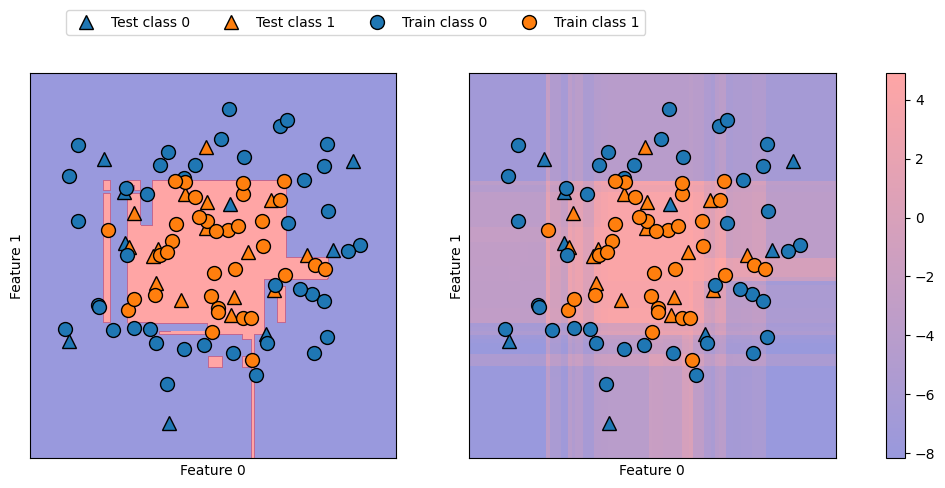

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5)) 
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, 
                                fill=True, cm=mglearn.cm2) 
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], 
                                            alpha=.4, cm=mglearn.ReBl) 
for ax in axes: 
    # 画出训练点和测试点 
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, 
                             markers='^', ax=ax) 
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, 
                             markers='o', ax=ax) 
    ax.set_xlabel("Feature 0") 
    ax.set_ylabel("Feature 1") 
cbar = plt.colorbar(scores_image, ax=axes.tolist()) 
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", 
                "Train class 1"], ncol=4, loc=(.1, 1.1))

图2-55：梯度提升模型在一个二维玩具数据集上的决策边界（左）和决策函数（右）

#### Explaination
➤ Left Plot: Decision Boundary

- Shows the **region** where the model predicts each class.
- Blue areas = predicted class 0 (`'blue'`)
- Red areas = predicted class 1 (`'red'`)
- The **boundary line** is where `decision_function = 0`

👉 This is what `predict()` uses to assign class labels.

⚠️ But note: Points near the boundary are uncertain 

— even though they get assigned a class, the model isn’t very confident. 

------------


➤ Right Plot: Decision Function (Color-Coded)

- **Red areas** = model is very confident it’s Class 1
- **Purple areas** = model is very confident it’s Class 0
- **White/Grey areas** = model is unsure — close to decision boundary

➡️ This gives you **much richer information** than just boundaries 

— you see **how confident** the model is everywhere.

----------


🔁 **Why These Two Views Are Powerful Together**

| View | What You Learn | Use Case |
| --- | --- | --- |
| **Left (Boundary)** | “Which class does the model assign?” | Final prediction |
| **Right (Scores)** | “How confident is the model?” | Risk assessment, uncertainty-aware decisions |

➡️ Example: In medical diagnosis, if a patient’s data point falls in a **gray zone**, you might say:

> “Model says ‘Class 1’, but confidence is low — recommend further tests.”


既给出预测结果，又给出分类器的置信程度，这样给出的信息量更大。但在上面的图像
中，很难分辨出两个类别之间的边界。

## Predicted Probabilities

This method returns the **estimated probability** that each sample belongs to each class.

> 💡 Unlike `decision_function`, which gives raw, unbounded scores — `predict_proba` gives **calibrated, interpretable probabilities** between 0 and 1.

For binary classification:

- Output shape: `(n_samples, 2)`
- Each row = `[P(class_0), P(class_1)]`
- Sum of each row = 1 → because it’s a probability distribution.

In [19]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


➡️ This means:

You have 25 test samples.
For each, you get 2 numbers → probability for Class 0 and Class 1.

In [21]:
# View First Few Probabilities
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


> ✅ Since probabilities sum to 1, **only one class can be > 50%** — that’s the model’s final prediction.

由于概率是浮点数，所以不太可能两个都等于0.500。但如果出现了这种情况，预测结果是随机选择的

在上一个输出中可以看到，分类器对大部分点的置信程度都是相对较高的。

不确定度大小实际上反映了数据依赖于模型和参数的不确定度。

**过拟合更强的模型可能会做出置信程度更高的预测，即使可能是错的**

**复杂度越低的模型通常对预测的不确定度越大**

### Calibrated Model
  
如果模型给出的不确定度符合实际情况，那么这个模型被称为**校正（calibrated）模型**。
  
在校正模型中，如果预测有70%的确定度，那么它在70%的情况下正确。

### Visaulize the boundary

  在下面的例子中（图2-56），我们再次给出该数据集的决策边界，以及类别1的类别概率：

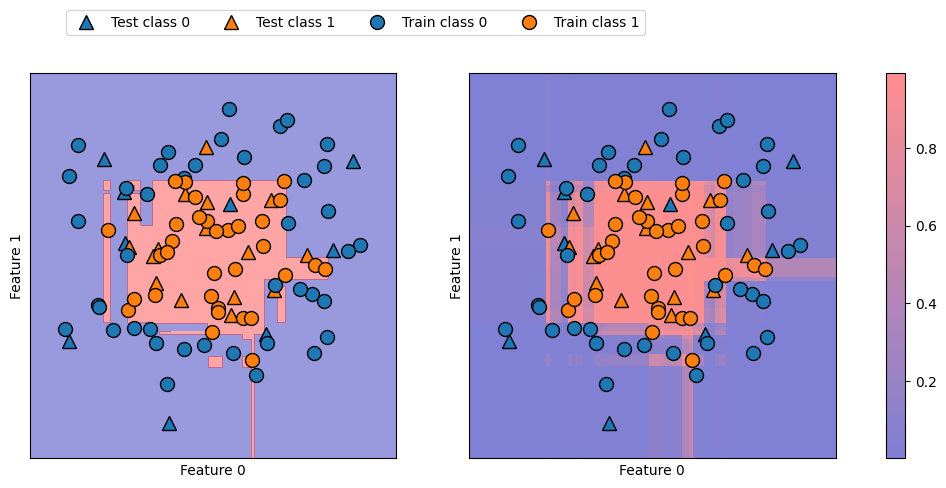

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5)) 
mglearn.tools.plot_2d_separator( 
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2) 
scores_image = mglearn.tools.plot_2d_scores( 
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba') 
for ax in axes: 
    # 画出训练点和测试点
     mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, 
                             markers='^', ax=ax) 
     mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, 
                             markers='o', ax=ax) 
     ax.set_xlabel("Feature 0") 
     ax.set_ylabel("Feature 1") 
cbar = plt.colorbar(scores_image, ax=axes.tolist()) 
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", 
                "Train class 1"], ncol=4, loc=(.1, 1.1))

图2-56：图2-55中梯度提升模型的决策边界（左）和预测概率

这张图中的边界更加明确，不确定的小块区域清晰可见

## Summary of the two methods

| Aspect | `decision_function` | `predict_proba` |
| --- | --- | --- |
| Range | Any number (-∞ to +∞) | Fixed: 0 to 1 |
| Meaning | Distance from boundary | Likelihood of being in Class 1 |
| Human Interpretation | ❌ Hard — needs reference | ✅ Easy — “90% chance” |
| Threshold Setting | Arbitrary (e.g., >0) | Meaningful (e.g., >0.7) |
| Model Comparison | Not comparable across models | Directly comparable |
| Best For | Technical analysis, ranking | Business logic, safety-critical apps |

---
### Example: weather forecast

**Think of It Like This: Weather Forecast**

Imagine you’re checking the weather app before going out.

 ➤ Option A: “Decision Function” Forecast

> ❄️ “The cold index is -4.2 today.”

➡️ What does that mean? Is it freezing? Mild? Snowing?

You don’t know unless you’ve memorized what “-4.2” means on this scale — which no one has.

This is like `decision_function`:  
→ It tells you *direction* (cold vs warm) and *relative strength*, but **no absolute meaning**.

---

➤ Option B: “Predict Proba” Forecast

> ☀️ “There’s a 95% chance of sunshine.”

➡️ Instantly understandable! You know:

- 95% = very likely sunny → pack sunglasses.
- 50% = maybe bring umbrella.
- 5% = definitely bring raincoat.

This is like `predict_proba`:  
→ It gives you a **direct, human-readable confidence level** — between 0% and 100%.


# Uncertainty Estimation in Multiclass Problems
## Example: Iris dataset
到目前为止，我们只讨论了二分类问题中的不确定度估计。但decision_function和
predict_proba 也适用于多分类问题。我们将这两个函数应用于鸢尾花（Iris）数据集，这
是一个三分类数据集：

In [23]:
from sklearn.datasets import load_iris 
iris = load_iris() 
X_train, X_test, y_train, y_test = train_test_split( 
    iris.data, iris.target, random_state=42) 
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0) 
gbrt.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.01
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [24]:
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape)) 
# 显示决策函数的前几个元素 
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function:
[[-0.89604809  1.14724958 -0.82754003]
 [ 1.16113086 -0.80789044 -0.82827067]
 [-0.89091511 -0.77671169  1.19653416]
 [-0.89604809  1.14724958 -0.82754003]
 [-0.89763468  0.96497584 -0.10374792]
 [ 1.16113086 -0.80789044 -0.82827067]]


对于多分类的情况，decision_function的形状为(n_samples, n_classes)，每一列对应每
个类别的“确定度分数”，分数较高的类别可能性更大，得分较低的类别可能性较小。

你可以找出每个数据点的最大元素，从而利用这些分数再现预测结果：

In [25]:
print("Argmax of decision function:\n{}".format( 
      np.argmax(gbrt.decision_function(X_test), axis=1))) 
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


predict_proba 输出的形状相同，也是(n_samples, n_classes)。同样，每个数据点所有可
能类别的概率之和为1：

In [26]:
# 显示predict_proba的前几个元素 
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# 显示每行的和都是1 
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
Sums: [1. 1. 1. 1. 1. 1.]


同样，我们可以通过计算predict_proba的argmax来再现预测结果：

In [28]:
print("Argmax of predicted probabilities:\n{}".format( 
      np.argmax(gbrt.predict_proba(X_test), axis=1))) 
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


### what is argmax
🔹 argmax stands for "argument of the maximum" — it means:

💡 "Which index has the highest value?" 

It does not return the maximum value itself — it returns the position (index) where that maximum occurs.

总之，**predict_proba 和 decision_function 的形状始终相同**，都是(n_samples, n_classes)——除了二分类特殊情况下的decision_function。

---------


### Use Real Class Names (Logistic Regression Example)

对于二分类的情况，decision_function 只有一列，对应“正”类classes_[1]。这主要是由于历史原因。

如果有n_classes 列，你可以通过计算每一列的argmax来再现预测结果。

但如果类别是字符串，或者是整数，但不是从0开始的连续整数的话，一定要小心。

如果你想要对比predict 的结果与decision_function 或 predict_proba 的结果，一定要用分类器的classes_ 属性来获取真实的属性名称：


In [31]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression() 
# 用Iris数据集的类别名称来表示每一个目标值 
named_target = iris.target_names[y_train] 
logreg.fit(X_train, named_target) 
print("unique classes in training data: {}".format(logreg.classes_)) 
print("predictions: {}".format(logreg.predict(X_test)[:10])) 
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1) 
print("argmax of decision function: {}".format(argmax_dec_func[:10])) 
print("argmax combined with classes_: {}".format( 
        logreg.classes_[argmax_dec_func][:10]))

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


➡️ This shows:

- Even if you train on string labels (`'setosa'`, etc.), scikit-learn internally maps them to integers.
- But when you call `.predict()`, it returns the **original string labels**.
- If you use `argmax` manually, you must combine it with `clf.classes_` to get the real names.

# Summary Table: Binary vs Multiclass

| Feature | Binary Classification | Multiclass Classification |
| --- | --- | --- |
| `decision_function` | Shape `(n, )` — one score | Shape `(n, n_classes)` — one per class |
| `predict_proba` | Shape `(n, 2)` — P(0), P(1) | Shape `(n, n_classes)` — one prob per class |
| Prediction Method | Sign of score | `argmax(score)` or `argmax(prob)` |
| Class Mapping | `classes_[0]` = negative, `classes_[1]` = positive | `classes_[i]` = label for index i |
| Interpretability | Medium | High (especially with `predict_proba`) |